# Text and Annotation

Creating a good visualization involves guiding the reader so that the figure tells a story.
In some cases, this story can be told in an entirely visual manner, without the need for added text, but in others, small textual cues and labels are necessary.
Perhaps the most basic types of annotations you will use are axes labels and titles, but the options go beyond this.
Let's take a look at some data and how we might visualize and annotate it to help convey interesting information. We'll start by setting up the notebook for plotting and  importing the functions we will use:

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-v0_8-whitegrid')   # for matplotlib >=3.6
import numpy as np
import pandas as pd

## Example: Effect of Holidays on US Births

Let's return to some data we worked with earlier, in [Example: Birthrate Data](03.09-Pivot-Tables.ipynb#Example:-Birthrate-Data), where we generated a plot of average births over the course of the calendar year. We'll start with the same cleaning procedure we used there, and plot the results (see the following figure):

In [2]:
# shell command to download the data:
# !cd data && curl -O \
#   https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

In [3]:
from datetime import datetime

births = pd.read_csv('data/births.csv')

quartiles = np.percentile(births['births'], [25, 50, 75])
mu, sig = quartiles[1], 0.74 * (quartiles[2] - quartiles[0])
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')

births['day'] = births['day'].astype(int)

births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')
births_by_date = births.pivot_table('births',
                                    [births.index.month, births.index.day])
births_by_date.index = [datetime(2012, month, day)
                        for (month, day) in births_by_date.index]

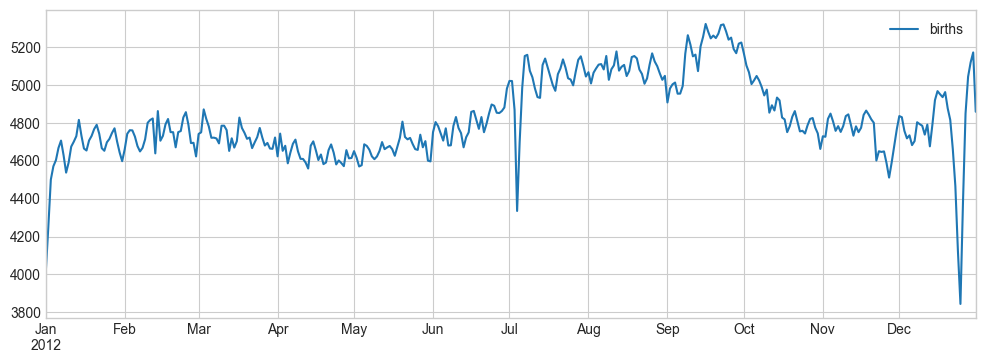

In [4]:
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

When we're visualizing data like this, it is often useful to annotate certain features of the plot to draw the reader's attention.
This can be done manually with the `plt.text`/`ax.text` functions, which will place text at a particular *x*/*y* value (see the following figure):

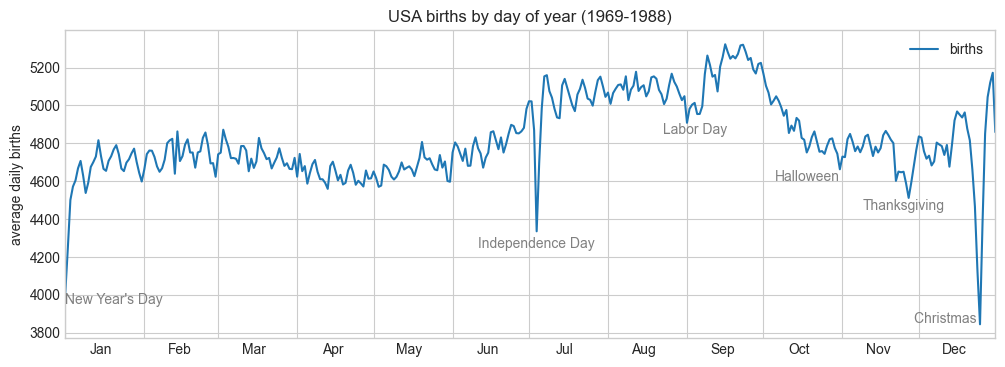

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax)

# Add labels to the plot
style = dict(size=10, color='gray')

ax.text('2012-1-1', 3950, "New Year's Day", **style)
ax.text('2012-7-4', 4250, "Independence Day", ha='center', **style)
ax.text('2012-9-4', 4850, "Labor Day", ha='center', **style)
ax.text('2012-10-31', 4600, "Halloween", ha='right', **style)
ax.text('2012-11-25', 4450, "Thanksgiving", ha='center', **style)
ax.text('2012-12-25', 3850, "Christmas ", ha='right', **style)

# Label the axes
ax.set(title='USA births by day of year (1969-1988)',
       ylabel='average daily births')

# Format the x-axis with centered month labels
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%h'));

The `ax.text` method takes an *x* position, a *y* position, a string, and then optional keywords specifying the color, size, style, alignment, and other properties of the text.
Here we used `ha='right'` and `ha='center'`, where `ha` is short for *horizontal alignment*.
See the docstrings of `plt.text` and `mpl.text.Text` for more information on the available options.

## Transforms and Text Position

In the previous example, we anchored our text annotations to data locations. Sometimes it's preferable to anchor the text to a fixed position on the axes or figure, independent of the data. In Matplotlib, this is done by modifying the *transform*.

Matplotlib makes use of a few different coordinate systems: a data point at $(x, y) = (1, 1)$ corresponds to a certain location on the axes or figure, which in turn corresponds to a particular pixel on the screen.
Mathematically, transforming between such coordinate systems is relatively straightforward, and Matplotlib has a well-developed set of tools that it uses internally to perform these transforms (these tools can be explored in the `matplotlib.transforms` submodule).

A typical user rarely needs to worry about the details of the transforms, but it is helpful knowledge to have when considering the placement of text on a figure. There are three predefined transforms that can be useful in this situation:

- `ax.transData`: Transform associated with data coordinates
- `ax.transAxes`: Transform associated with the axes (in units of axes dimensions)
- `fig.transFigure`: Transform associated with the figure (in units of figure dimensions)

Let's look at an example of drawing text at various locations using these transforms (see the following figure):

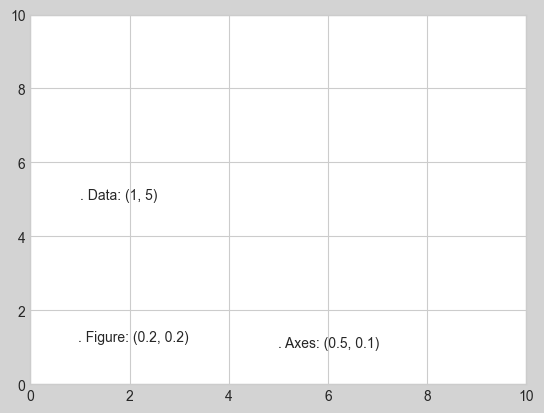

In [6]:
fig, ax = plt.subplots(facecolor='lightgray')
ax.axis([0, 10, 0, 10])

# transform=ax.transData is the default, but we'll specify it anyway
ax.text(1, 5, ". Data: (1, 5)", transform=ax.transData)
ax.text(0.5, 0.1, ". Axes: (0.5, 0.1)", transform=ax.transAxes)
ax.text(0.2, 0.2, ". Figure: (0.2, 0.2)", transform=fig.transFigure);

Matplotlib's default text alignment is such that the "." at the beginning of each string will approximately mark the specified coordinate location.

The `transData` coordinates give the usual data coordinates associated with the x- and y-axis labels.
The `transAxes` coordinates give the location from the bottom-left corner of the axes (here the white box), as a fraction of the total axes size.
The `transFigure` coordinates are similar, but specify the position from the bottom-left corner of the figure (here the gray box) as a fraction of the total figure size.

Notice now that if we change the axes limits, it is only the `transData` coordinates that will be affected, while the others remain stationary (see the following figure):

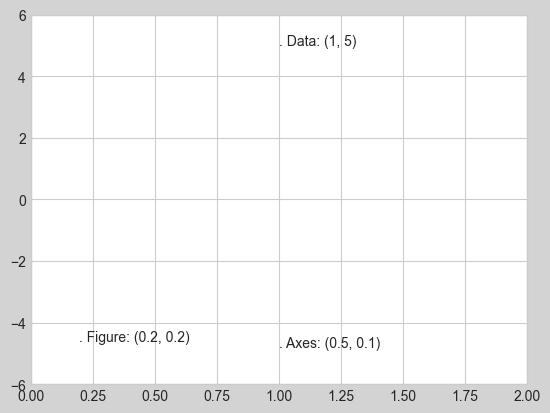

In [7]:
ax.set_xlim(0, 2)
ax.set_ylim(-6, 6)
fig

This behavior can be seen more clearly by changing the axes limits interactively: if you are executing this code in a notebook, you can make that happen by changing `%matplotlib inline` to `%matplotlib notebook` and using each plot's menu to interact with the plot.

## Arrows and Annotation

Along with tickmarks and text, another useful annotation mark is the simple arrow.

While there is a `plt.arrow` function available, I wouldn't suggest using it: the arrows it creates are SVG objects that will be subject to the varying aspect ratio of your plots, making it tricky to get them right.
Instead, I'd suggest using the `plt.annotate` function, which creates some text and an arrow and allows the arrows to be very flexibly specified.

Here is a demonstration of `annotate` with several of its options (see the following figure):

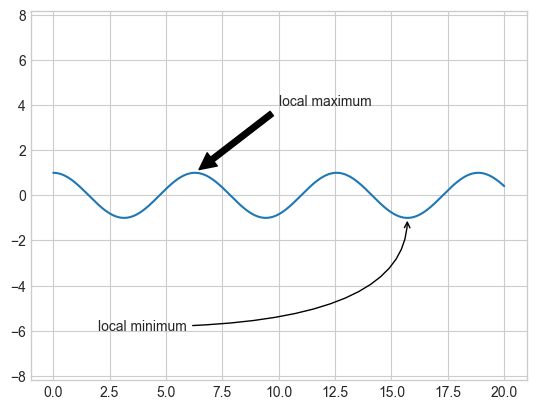

In [8]:
fig, ax = plt.subplots()

x = np.linspace(0, 20, 1000)
ax.plot(x, np.cos(x))
ax.axis('equal')

ax.annotate('local maximum', xy=(6.28, 1), xytext=(10, 4),
            arrowprops=dict(facecolor='black', shrink=0.05))

ax.annotate('local minimum', xy=(5 * np.pi, -1), xytext=(2, -6),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"));

The arrow style is controlled through the `arrowprops` dictionary, which has numerous options available.
These options are well documented in Matplotlib's online documentation, so rather than repeating them here it is probably more useful to show some examples.
Let's demonstrate several of the possible options using the birthrate plot from before (see the following figure):

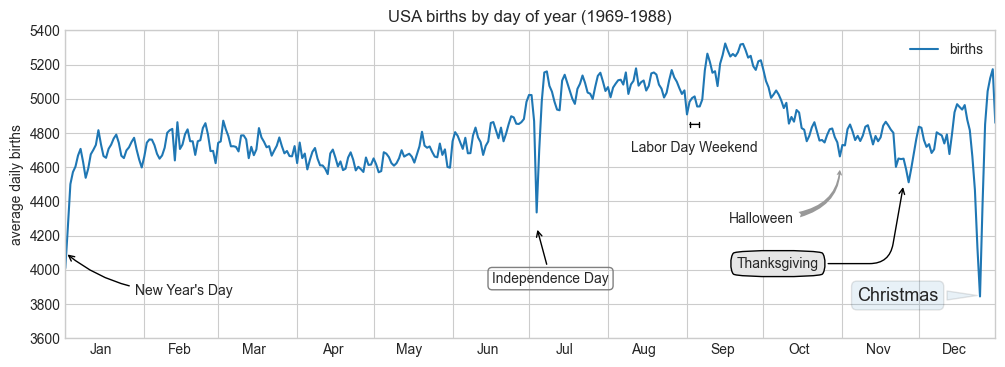

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax)

# Add labels to the plot
ax.annotate("New Year's Day", xy=('2012-1-1', 4100),  xycoords='data',
            xytext=(50, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))

ax.annotate("Independence Day", xy=('2012-7-4', 4250),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(10, -40), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.annotate('Labor Day Weekend', xy=('2012-9-4', 4850), xycoords='data',
            ha='center', xytext=(0, -20), textcoords='offset points')
ax.annotate('', xy=('2012-9-1', 4850), xytext=('2012-9-7', 4850),
            xycoords='data', textcoords='data',
            arrowprops={'arrowstyle': '|-|,widthA=0.2,widthB=0.2', })

ax.annotate('Halloween', xy=('2012-10-31', 4600),  xycoords='data',
            xytext=(-80, -40), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('Thanksgiving', xy=('2012-11-25', 4500),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))


ax.annotate('Christmas', xy=('2012-12-25', 3850),  xycoords='data',
             xytext=(-30, 0), textcoords='offset points',
             size=13, ha='right', va="center",
             bbox=dict(boxstyle="round", alpha=0.1),
             arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1));

# Label the axes
ax.set(title='USA births by day of year (1969-1988)',
       ylabel='average daily births')

# Format the x-axis with centered month labels
ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%h'));

ax.set_ylim(3600, 5400);

The variety of options make `annotate` powerful and flexible: you can create nearly any arrow style you wish.
Unfortunately, it also means that these sorts of features often must be manually tweaked, a process that can be very time-consuming when producing publication-quality graphics!
Finally, I'll note that the preceding mix of styles is by no means best practice for presenting data, but rather is included as a demonstration of some of the available options.

More discussion and examples of available arrow and annotation styles can be found in the Matplotlib [Annotations tutorial](https://matplotlib.org/stable/tutorials/text/annotations.html).